In [4]:
import numpy as np
np.random.seed(1001)

import os
import shutil
import librosa
from librosa import display

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
# from sklearn.cross_validation import StratifiedKFold

%matplotlib inline
matplotlib.style.use('ggplot')

In [5]:

train = pd.read_csv("../../../ESC-50/meta/esc50.csv")
# TARGETS = [0,2,4,5,6,7,8] #,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]
# train = train[train['target'].isin(TARGETS)]

In [6]:
# X_train = np.load('X4', 'X_train.npy')
FNAME_COLUMN = 'filename'
LNAME_COLUMN = 'category'
labels = train[LNAME_COLUMN].unique()
i2label = [l for i, l in enumerate(labels) if i in [8, 9, 10, 13, 16, 24, 26, 32, 35, 46]]
i2label

['fireworks',
 'chainsaw',
 'airplane',
 'train',
 'church_bells',
 'car_horn',
 'helicopter',
 'engine',
 'hand_saw',
 'siren']

In [7]:
# Use filter for remove Animals & Outdoor sound
# labels_map = {'dog': ['dag'],
#               'crying_baby': ['crying_baby'],
#               'animals': ['crow', 'sheep', 'frog', 'cow', 'insects', 'hen', 'pig', 'rooster', 'cat'],
#               'natural': ['chirping_birds','thunderstorm','pouring_water', 'water_drops', 'wind', 'crackling_fire',
#                           'rain', 'toilet_flush', 'sea_waves', 'crickets'],
#               'human_non_speech': ['clapping', 'footsteps',  'brushing_teeth',  'drinking_sipping', 'laughing',
#                                    'breathing', 'coughing', 'snoring', 'sneezing'],
#               'domestic': ['vacuum_cleaner', 'door_wood_knock', 'can_opening', 'mouse_click', 'clock_alarm',
#                            'keyboard_typing', 'glass_breaking', 'washing_machine', 'clock_tick', 'door_wood_creaks'],
#               'urban': ['fireworks', 'chainsaw', 'airplane', 'train', 'church_bells', 'car_horn', 'helicopter',
#                         'engine', 'hand_saw', 'siren']}
                  

# for lmap in labels_map.keys():
#     train.loc[train[LNAME_COLUMN].isin(labels_map[lmap]), LNAME_COLUMN] = lmap

    
# train.head()
labels = train[LNAME_COLUMN].value_counts(normalize=False)
labels

car_horn            40
drinking_sipping    40
crickets            40
hen                 40
chirping_birds      40
door_wood_creaks    40
laughing            40
clock_tick          40
frog                40
cow                 40
keyboard_typing     40
mouse_click         40
pouring_water       40
chainsaw            40
wind                40
clock_alarm         40
dog                 40
sneezing            40
can_opening         40
rooster             40
washing_machine     40
train               40
vacuum_cleaner      40
cat                 40
engine              40
coughing            40
crying_baby         40
snoring             40
fireworks           40
crow                40
airplane            40
clapping            40
door_wood_knock     40
church_bells        40
breathing           40
helicopter          40
sheep               40
thunderstorm        40
crackling_fire      40
footsteps           40
water_drops         40
sea_waves           40
toilet_flush        40
insects    

In [8]:
df_test = train[train['fold'] == 5]
df_test = df_test[df_test['category'] == 'crying_baby']
df_test.head()

,filename,fold,target,category,esc10,src_file,take
1617,5-151085-A-20.wav,5,20,crying_baby,True,151085,A
1728,5-198411-A-20.wav,5,20,crying_baby,True,198411,A
1729,5-198411-B-20.wav,5,20,crying_baby,True,198411,B
1730,5-198411-C-20.wav,5,20,crying_baby,True,198411,C
1731,5-198411-D-20.wav,5,20,crying_baby,True,198411,D


In [9]:
from pathlib import Path

FNAME_COLUMN = 'filename'
LNAME_COLUMN = 'category'

# Path's
dataroot = Path('../../..') / 'donateacry-corpus'
dataroot_train = dataroot / 'audio'

# Data frames for train/test dataset
audio_train_files = os.listdir(str(dataroot_train))

df = pd.DataFrame()
df[FNAME_COLUMN] = audio_train_files
df[LNAME_COLUMN] = 'crying_baby'

# Labels and integer converter
if 'crying_baby' not in labels:
    labels.append('crying_baby')
    label2int = {l: i for i, l in enumerate(labels)}
    num_classes = len(labels)

# Plain y_train label
plain_y_train = np.array([label2int[label] for label in df[LNAME_COLUMN]])

NameError: name 'label2int' is not defined

In [10]:
df.head()

,filename,category
0,021DCB9F-2FC6-4247-859F-E58EDB682B79-142997725...,crying_baby
1,021DCB9F-2FC6-4247-859F-E58EDB682B79-142997726...,crying_baby
2,03abcb8f-400a-47d8-ad82-7e4586cc06be-143186419...,crying_baby
3,03ADDCFB-354E-416D-BF32-260CF47F7060-143365802...,crying_baby
4,045C5483-69E1-4BEC-B1D8-9286D174B9B2-143010299...,crying_baby


In [22]:
from sklearn.model_selection import train_test_split

labels=[]

# Path's
dataroot = Path('../../..') / 'FreesoundScream'
dataroot_train = dataroot / 'audio'
dataroot_test = dataroot_train

# Data frames for train/test dataset
audio_train_files = os.listdir(str(dataroot_train))
df = pd.DataFrame()
df[FNAME_COLUMN] = audio_train_files
df[LNAME_COLUMN] = 'scream'

# Labels and integer converter
if 'scream' not in labels:
    labels.append('scream')
    label2int = {l: i for i, l in enumerate(labels)}
    num_classes = len(labels)

# Split into training and test set
df_train, df_test, y_train, y_test = train_test_split(df[FNAME_COLUMN], df[LNAME_COLUMN],
                                                      test_size=0.2,
                                                      random_state=42,
                                                      shuffle=True)

In [23]:
conf = confX 
print('== Attempt [%s] ==' % conf['folder'])

# a. Load all dataset -> all_(X4|y|idx)_train, (X4|idx)_test
all_X_train, all_y_train, all_idx_train = \
    loaddata(conf, 'X_train.npy'), \
    to_categorical(loaddata(conf, 'y_train.npy')), \
    loaddata(conf, 'idx_train.npy')

X_test, idx_test = loaddata(conf, 'X_test.npy'), loaddata(conf, 'idx_test.npy')

for dataroot_extra in DATAROOT_EXTRA:
    if os.path.exists(dataroot_extra / datapath(conf, 'X_train.npy')):
        all_X_train_extra, all_y_train_extra, all_idx_train_extra = \
            np.load(dataroot_extra / conf['folder'] / 'X_train.npy'), \
            to_categorical(np.load(dataroot_extra / conf['folder'] / 'y_train.npy')), \
            np.load(dataroot_extra / conf['folder'] / 'idx_train.npy')

        #
        all_X_train += all_X_train_extra
        all_y_train += all_y_train_extra
        all_idx_train += all_idx_train_extra

    if os.path.exists(dataroot_extra / datapath(conf, 'X_test.npy')):
        X_test_extra, idx_test_extra = np.load(dataroot_extra / conf['folder'] / 'X_test.npy'), \
                                       np.load(dataroot_extra / conf['folder'] / 'idx_test.npy')

        X_test, idx_test = X_test + X_test_extra, idx_test + idx_test_extra


== Attempt [X3] ==


NameError: name 'loaddata' is not defined

Text(0, 0.5, 'Number of Samples')

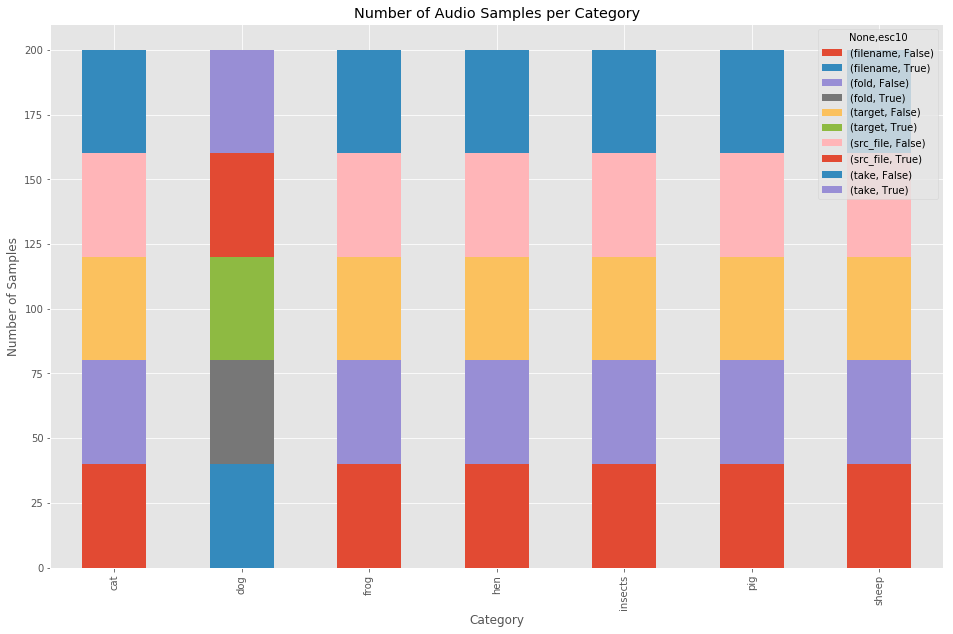

In [12]:
category_group = train[train['target'].isin(TARGETS)].groupby(['category', 'esc10']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples")

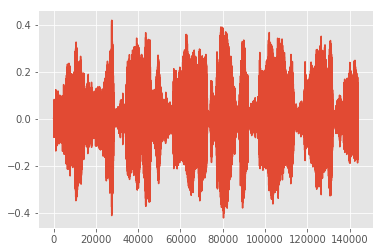

In [30]:
from scipy.io import wavfile
import IPython.display as ipd  # To play sound in the notebook

from pydub import AudioSegment
from pydub.utils import mediainfo

# t_fname = 'C:\\Users\\User\\Downloads\\Skype\\03_14_false_rec_cry_NEST.wav'
# t_fname = 'C:\\Users\\User\\Downloads\\Skype\\03_26_IL_bbcry_no_detects.wav'
# t_fname = '../audio_samples/V_2017-04-01+08_04_36=0_13.mp3'
t_fname = r'../audio_samples/signal_9s.wav'
# t_fname = '../../../donateacry-corpus/donateacry-ios-upload-bucket/0D1AD73E-4C5E-45F3-85C4-9A3CB71E8856-1430738409-1.0-m-04-hu.caf'

t_signal, rate = librosa.load(t_fname, sr=16000)
# t_signal = t_signal.astype('float64')

# rate, t_signal = wavfile.read(t_fname)

# sound = AudioSegment.from_file(r"../audio_samples/signal_9s.wav", format="raw",
#                                    frame_rate=16000, channels=1, sample_width=2)
# sound = sound.set_frame_rate(16000)
# sound = sound.set_sample_width(2) # 16bit
# t_signal = np.array(sound.get_array_of_samples())  # Extract signal samples

# https://www.kaggle.com/holzner/voice-activity-detection-example
# 16 bits tracks, normalization
# t_signal = np.array([(e/2**16.0) * 2 for e in t_signal])
min_len = len(t_signal)

t_signal = t_signal[:min_len]
new_sig = t_signal

# new_sig_16b = np.array([int((v*2**16.0)/2) for v in new_sig])
new_sig_16b = new_sig
plt.plot(new_sig_16b)

ipd.Audio(new_sig_16b, rate=rate)

In [41]:
import struct
import webrtcvad

def get_config_default():

    confX = {}
    confX['folder'] = 'X5S'

    # Approach X4 uses longer sound, then it uses suppressed
    confX['sampling_rate'] = 16000
    confX['duration'] = 5
    confX['hop_length'] = 320
    confX['fmin'] = 20
    confX['fmax'] = confX['sampling_rate'] // 2
    confX['n_mels'] = 48
    confX['n_mfcc'] = 48
    confX['n_fft'] = confX['n_mels'] * 20
    confX['audio_split'] = 'dont_crop'

    return confX

def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio,
                                                 sr=conf['sampling_rate'],
                                                 n_mels=conf['n_mels'],
                                                 hop_length=conf['hop_length'],
                                                 n_fft=conf['n_fft'],
                                                 fmin=conf['fmin'],
                                                 fmax=conf['fmax'])
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    # (48, 504)
    return spectrogram


def show_melspectrogram(mels, conf):
    librosa.display.specshow(mels,
                             x_axis='time',
                             y_axis='mel',
                             sr=conf['sampling_rate'],
                             hop_length=conf['hop_length'],
                             fmin=conf['fmin'],
                             fmax=conf['fmax'])
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-frequency power spectrogram')
    plt.show()

def vad(samples, conf, normalize=True):
    """
    Use normalize for librosa lib
    :param samples:
    :param conf:
    :param normalize:
    :return:
    """

    vad = webrtcvad.Vad()

    # set aggressiveness from 0 to 3
    vad.set_mode(3)
    if normalize:
        speech_samples_norm = np.array([int((v * 2 ** 16.0)) for v in samples])
        max_sample = max(speech_samples_norm)
        print(max_sample)
#         speech_samples_norm = [ int(n / max_noise * 2 ** 16) for n in speech_samples_norm]
    else:
        speech_samples_norm = samples

    raw_samples = struct.pack("%dh" % len(speech_samples_norm), *speech_samples_norm)
    window_duration = 0.02  # duration in seconds
    samples_per_window = int(window_duration * conf['sampling_rate'] + 0.5)
    bytes_per_sample = 2

    segments = []
    for start in np.arange(0, len(samples), samples_per_window):
        stop = min(start + samples_per_window, len(samples))

        try:
            is_speech = vad.is_speech(raw_samples[start * bytes_per_sample: stop * bytes_per_sample],
                                      sample_rate=conf['sampling_rate'])

            segments.append(dict(start=start, stop=stop, is_speech=is_speech))

        except:
            continue

    speech_chunk = []
    full_chunks = []
    for ind, segment in enumerate(segments):
        if segment['is_speech']:
            speech_chunk.append(ind)
        elif not segment['is_speech']:
            if len(speech_chunk) > 0:
                speech_samples = np.concatenate([samples[sg['start']:sg['stop']] for sg in np.array(segments)[speech_chunk]])
                if len(speech_samples) > 6400:
                    full_chunks.append(speech_samples)
                speech_chunk = []

    return full_chunks

In [38]:
confX = {}
confX['duration'] = 5
confX['folder'] = 'X%dS' % confX['duration']
print(confX['folder'])

X5S


In [42]:
conf = get_config_default()

xx = vad(t_signal, conf)
melss = []
for x in xx:
    mels = audio_to_melspectrogram(conf, x)
    melss.append(mels)

#     IPython.display.display(IPython.display.Audio(x, rate=conf['sampling_rate']))
#     show_melspectrogram(mels, conf)

9888


In [43]:
print(2 ** 15)

32768


In [ ]:
import IPython.display as ipd
from scipy.io import wavfile
from scipy import interpolate
import webrtcvad
import struct
from pydub import AudioSegment
from pydub.utils import mediainfo

vad = webrtcvad.Vad()

# set aggressiveness from 0 to 3
vad.set_mode(3)

# ipd.display(ipd.Audio(r"../audio_samples/signal_9s.wav"))
# sample_rate, samples = wavfile.read(r"E:/tmp/chunks/183bbae8-e207-44bc-86ee-617d59788277\chunk50.wav")
# sample_rate, samples = wavfile.read(r"../audio_samples/Short3.wav")
# sound = AudioSegment.from_wav(r"../audio_samples/signal_9s.wav")  # Read audio file

sound = AudioSegment.from_file(r"../audio_samples/signal_9s.wav", format="raw",
                                   frame_rate=44100, channels=1, sample_width=2)
sound = sound.set_frame_rate(16000)
sound = sound.set_sample_width(2) # 16bit
samples = np.array(sound.get_array_of_samples())  # Extract signal samples
sample_rate = sound.frame_rate  # Sampling frequency

# From WavDecode CS
# samples = np.loadtxt(r"../audio_samples/silence.txt")
# sample_rate = 32000
# samples = np.array([int((v*2**16.0)/2) for v in samples])

# sample_rate, samples = wavfile.read(r"../audio_samples/AudioTrack-2.wav")
#samples, sample_rate = librosa.load(r"E:/tmp/chunks/183bbae8-e207-44bc-86ee-617d59788277\chunk50.wav", sr=16000)
# samples = np.array([(e/2**16.0)*2 for e in samples])
# np.savetxt('../audio_samples/02_21_failcry_8of20_2.csv', samples, fmt="%d", delimiter=",")
print(samples.shape)
# print(max(samples))
# print(sample_rate)

In [ ]:
# Function to find short term energy

def short_term_energy(sig, winlen, fs):
    winsamp = int(winlen*fs)
    stesig = np.zeros((len(sig)))
    for ind in range(int(winsamp/2), int(len(sig)-winsamp/2)):
        sig_segment = sig[int(ind-winsamp/2):int(ind+winsamp/2)]
        stesig[ind] = np.sqrt(np.sum(np.multiply(sig_segment, sig_segment)))
#         stesig[ind] = np.sum(np.multiply(sig_segment, sig_segment))
        
    return stesig

In [ ]:
# Normilze to max amplitude of 1
# speech_samples_norm = np.array(samples)/np.max(np.array(samples))
# 16 bits tracks, normalization
# speech_samples_norm = np.array([(e/2**16.0)*2 for e in samples])
speech_samples_norm = samples

# Compute short term energy
winlen = .03  # Window length of 30 ms
stesig = short_term_energy(speech_samples_norm, winlen, sample_rate)
plt.plot(speech_samples_norm)

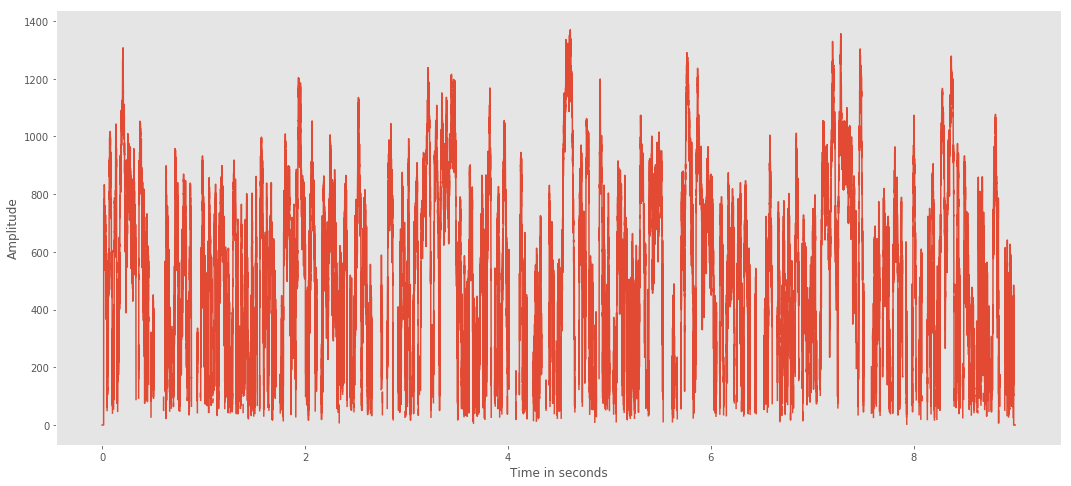

In [30]:
# Average short term energy in the whole speech signal
# avgsig = np.mean(stesig)*10**(0)

# stesig = [(v if v > avgsig else 0) for i, v in enumerate(stesig)]

# PLot short term energy
strt_samp = 0
end_samp = len(speech_samples_norm)
end_ms = len(speech_samples_norm)/sample_rate

xrange = np.linspace(0, end_ms, end_samp-strt_samp)

fg1 = plt.figure(figsize=(18, 8))

plt.plot(xrange, stesig)
plt.xlabel('Time in seconds')
plt.ylabel('Amplitude')
plt.grid()

In [31]:
%%time
import struct

raw_samples = struct.pack("%dh" % len(samples), *samples)
window_duration = 0.02 # duration in seconds
samples_per_window = int(window_duration * sample_rate + 0.5)
bytes_per_sample = 2
MaxSilenceAmplitude = 0.07

segments = []
power = []
noise = []
for start in np.arange(0, len(samples), samples_per_window):
    
    stop = min(start + samples_per_window, len(samples))
    
    norm = np.linalg.norm(samples[start : stop ])
    ns = np.linalg.norm(np.absolute(np.diff(np.sign(samples[start : stop ]))))
    power.append(norm)
    noise.append(ns)
    try:
        is_speech = vad.is_speech(raw_samples[start * bytes_per_sample: stop * bytes_per_sample],
                              sample_rate = sample_rate)
        
        segments.append(dict(
           start = start,
           stop = stop,
           is_speech = is_speech))

    except:
        pass
#     if is_speech != (norm > MaxSilenceAmplitude):
#         print(norm)

print(samples_per_window)

320
Wall time: 37 ms


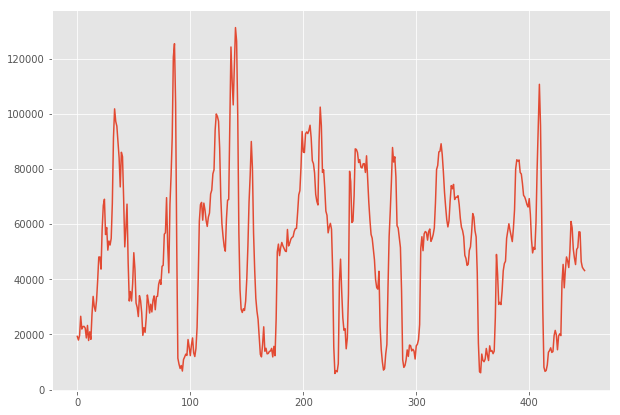

In [32]:
max_power = max(power)
# power = power / max_power
plt.figure(figsize = (10,7))
plt.plot(power)

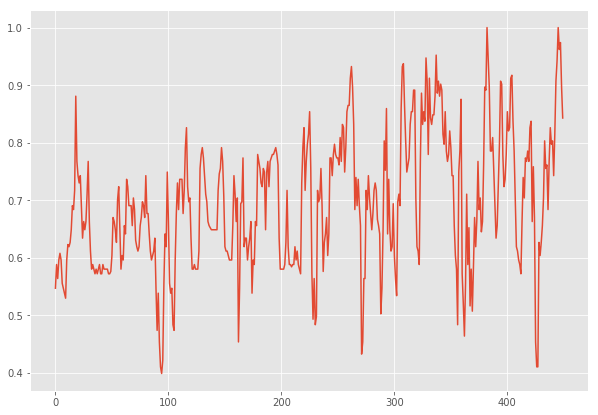

In [33]:
max_noise = max(noise)
noise = [ n / max_noise for n in noise]
plt.figure(figsize = (10,7))
plt.plot(noise)

In [34]:
# file = "C:\\Users\\User\\Downloads\\Skype\\03_26_IL_bbcry_no_detects.wav"
file = r"../audio_samples/leak-test-3.csv"
vad_test = np.loadtxt(file, delimiter=';', usecols = (0,1))


UnicodeDecodeError: 'charmap' codec can't decode byte 0x90 in position 65: character maps to <undefined>

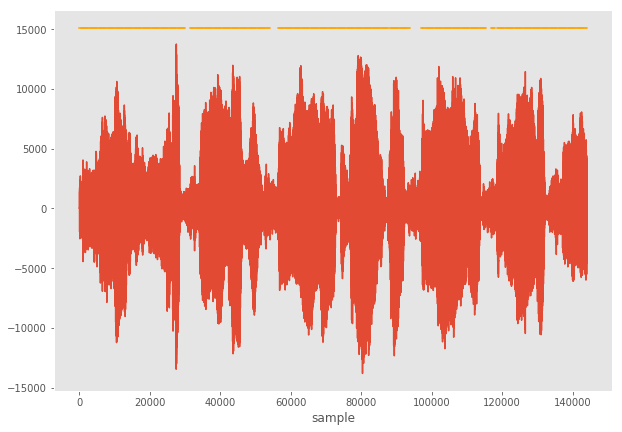

In [35]:
plt.figure(figsize = (10,7))
plt.plot(samples)

ymax = max(samples)
plt.xlabel('sample')
plt.grid()
# detected = []

# plot segment identifed as speech
for segment in segments:
    if segment['is_speech']:
        plt.plot([ segment['start'], segment['stop'] - 1], [ymax * 1.1, ymax * 1.1], color = 'orange')
#         detected.append(segment)
# for segment in vad_test:
#     plt.plot([ segment[0], segment[1] - 1], [ymax * 1.2, ymax * 1.2], color = 'orange')    

# print(detected)
speech_samples = np.concatenate([ samples[segment['start']:segment['stop']] for segment in segments if segment['is_speech']])
ipd.Audio(speech_samples, rate=sample_rate)

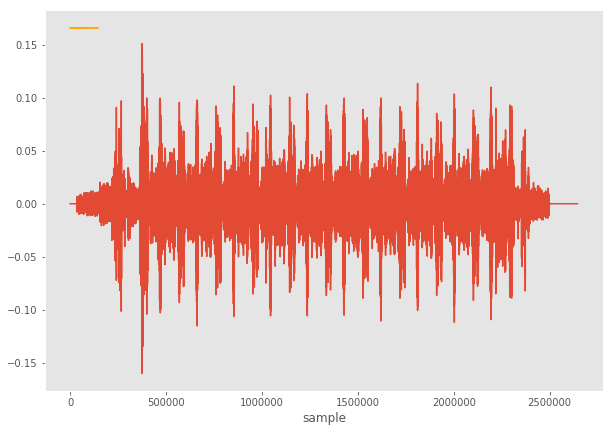

In [36]:
plt.figure(figsize = (10,7))
plt.plot(t_signal)

ymax = max(t_signal)

# plot segment identifed as speech
for segment in segments:
    if segment['is_speech']:
        plt.plot([ segment['start'], segment['stop'] - 1], [ymax * 1.1, ymax * 1.1], color = 'orange')

plt.xlabel('sample')
plt.grid()

In [6]:
class Config(object):
    def __init__(self,
                 sampling_rate=22050, 
                 n_classes=41,
                 train_dir='../AudioTagging/audio_train',
                 n_mels=64, 
                 frame_weigth=80, 
                 frame_shift=10):

        self.sampling_rate = sampling_rate
        self.n_classes = n_classes
        self.train_dir = train_dir

        self.n_fft = int(frame_weigth / 1000 * sampling_rate)
        self.n_mels = n_mels
        self.frame_weigth = frame_weigth
        self.frame_shift = frame_shift
        self.hop_length = int(frame_shift / 1000 * sampling_rate)

        
def get_subset(csv_file, n):
    """
    Train set is too big. We get a subset to display.
    """
    train = pd.read_csv(csv_file)
    train = train.sort_values(by=['label', 'fname'])

    LABELS = list(train.label.unique())

    subset = train.iloc[[0]]
    
    # choose n files from each category randomly.
    for label in LABELS:
        subset = subset.append(train[train.label == label].sample(n))

    subset = subset.iloc[1:]
    return subset

def get_folder_subset(dest='../../../baby_cry_detection/data/301 - Crying baby'):
#     dest = '../audio_samples'
#     dest = '../../../baby_cry_detection/data/301 - Crying baby'
    file_list = os.listdir(dest)
    df = pd.DataFrame({ "fname": file_list,
                        "label": 'crying_baby', 
                        "manually_verified": 1})
    return df


def add_subplot_axes(ax, position):
    box = ax.get_position()
    
    position_display = ax.transAxes.transform(position[0:2])
    position_fig = plt.gcf().transFigure.inverted().transform(position_display)
    x = position_fig[0]
    y = position_fig[1]
    
    return plt.gcf().add_axes(
        [x, y, box.width * position[2], box.height * position[3]],
        # axisbg='w'
    )


def plot_one_file(row, ax):
    fname = os.path.join(config.train_dir, row['fname'])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax_waveform = add_subplot_axes(ax, [0.0, 0.7, 1.0, 0.3])
    ax_logmel = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.7])
    
    data, _ = librosa.load(fname, sr=config.sampling_rate)
    melspec = librosa.feature.melspectrogram(data, 
                                             sr=config.sampling_rate,
                                             n_fft=config.n_fft, 
                                             hop_length=config.hop_length,
                                             n_mels=config.n_mels)

    logmel = librosa.core.power_to_db(melspec)
#     logmel = melspec
    
    ax_waveform.plot(data, '-')
    ax_waveform.get_xaxis().set_visible(False)
    ax_waveform.get_yaxis().set_visible(False)
    ax_waveform.set_title('{0} \n {1}'.format(row['label'], row['fname']), {'fontsize': 8}, y=1.03)

    librosa.display.specshow(logmel, sr=config.sampling_rate)
    ax_logmel.get_xaxis().set_visible(False)
    ax_logmel.get_yaxis().set_visible(False)


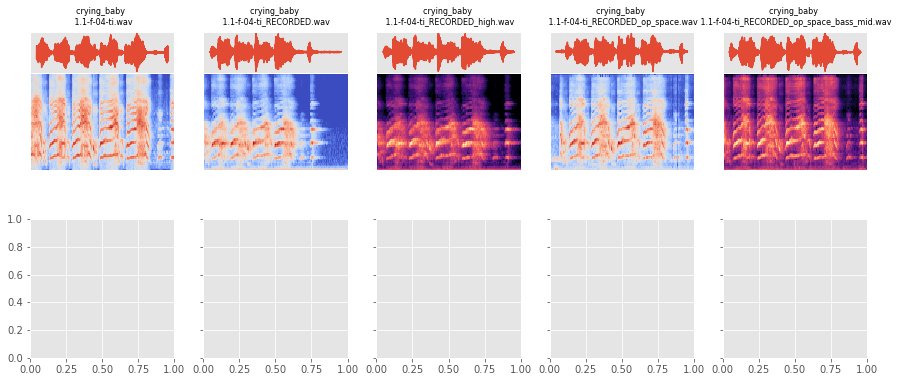

In [10]:
# frame_weight: 80ms, frame_shift:10ms
config = Config(sampling_rate=16000, 
                n_classes=2,
                frame_weigth=80, 
                frame_shift=10, 
                train_dir='../../../AudioTagging/audio_train')

files_shown = 5 
subset = get_subset('../../../AudioTagging/train.csv', files_shown)

f, axes = plt.subplots(config.n_classes,
                       files_shown,
                       figsize=(files_shown * 3, config.n_classes * 3),
                       sharex=True,
                       sharey=True)
f.subplots_adjust(hspace=0.35)

# print(subset)#

# for i, (_, row) in enumerate(subset.iterrows()):
#     plot_one_file(row, axes[i//files_shown, i%files_shown])

# train_dir='../../../baby_cry_detection/data/903 - Baby laugh'
train_dir = '../../output/recorded_sound'
config = Config(sampling_rate=16000, 
                frame_weigth=80, 
                frame_shift=10, 
                # train_dir='../audio_samples'
                train_dir=train_dir
               )
subset = get_folder_subset(dest=train_dir)
for i, (_, row) in enumerate(subset.iterrows()):
    plot_one_file(row, axes[i//files_shown, i%files_shown])
